In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import random as rn
import tensorflow as tf
import cv2
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
images = os.path.join('C:/Users/Saikumar/AI Miniproject/dataset','images')
annotations = os.path.join('C:/Users/Saikumar/AI Miniproject/dataset','annotations')

width = 80
height = 80
img_array = []
labels = []

def dim(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

for anot_file in sorted(os.listdir(annotations)):
    file_path = annotations + "/" + anot_file
    xml = ET.parse(file_path)
    root = xml.getroot()
    image = images + "/" + root[1].text

    for bndbox in root.iter('bndbox'):
        [xmin, ymin, xmax, ymax] = dim(bndbox)
        img = cv2.imread(image)
        img_pr = img[ymin:ymax,xmin:xmax]
        img_pr  = cv2.resize(img_pr,(width, height))
        img_array.append(np.array(img_pr))
    for obj in root.findall('object'):
        name = obj.find('name').text 
        labels.append(np.array(name)) 

### normalizing feature variable and encoding labels

In [4]:
x = np.array(img_array)
X = x/255

classes = 3
encode = LabelEncoder().fit(labels)
encoded_y = encode.transform(labels)
y = np_utils.to_categorical(encoded_y, classes)
y

array([[0., 0., 1.],
       [0., 1., 0.],
       [0., 0., 1.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [5]:
X.shape

(4072, 80, 80, 3)

In [6]:
train_x, val_x, train_y, val_y = train_test_split(X,y,test_size = 0.33,random_state = 42)

In [7]:
model = Sequential()
model.add(Conv2D(filters = 64,kernel_size = (3,3),activation = 'relu',padding = 'same',input_shape = (width, height, 3)))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 96,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(filters = 128,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(Conv2D(filters = 128,kernel_size = (3,3),activation = 'relu',padding = 'same'))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Flatten())
model.add(Dense(512,activation = 'relu'))
model.add(Dense(3,activation = "softmax"))

b_size = 80
n_epochs = 20

opt = optimizers.RMSprop(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss='kullback_leibler_divergence',
              metrics=['accuracy'])

In [8]:
datagen = ImageDataGenerator(rescale = 1./255.,
                             validation_split = 0.25,
                             rotation_range = 10,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             zoom_range = 0.2,
                             horizontal_flip = True,
                             brightness_range = [0.2,1.2])

reg = EarlyStopping(monitor = 'val_loss',patience = 2,verbose = 1,min_delta = 0.01)

train = model.fit(datagen.flow(train_x, train_y, batch_size = b_size), 
                    steps_per_epoch = train_x.shape[0]//b_size,
                    epochs = n_epochs, 
                    validation_data = (val_x,val_y), 
                    verbose=1, callbacks=[reg])

Epoch 1/20
34/34 [==============================] - 54s 2s/step - loss: 0.8662 - accuracy: 0.7500 - val_loss: 0.3269 - val_accuracy: 0.8772
Epoch 2/20
34/34 [==============================] - 51s 1s/step - loss: 0.3599 - accuracy: 0.8927 - val_loss: 0.2452 - val_accuracy: 0.9271
Epoch 3/20
34/34 [==============================] - 52s 2s/step - loss: 0.3246 - accuracy: 0.8931 - val_loss: 0.2106 - val_accuracy: 0.9323
Epoch 4/20
34/34 [==============================] - 55s 2s/step - loss: 0.3339 - accuracy: 0.8961 - val_loss: 0.2898 - val_accuracy: 0.9070
Epoch 5/20
34/34 [==============================] - 51s 1s/step - loss: 0.2744 - accuracy: 0.9177 - val_loss: 0.2435 - val_accuracy: 0.9338
Epoch 5: early stopping


Text(0, 0.5, 'Accuracy')

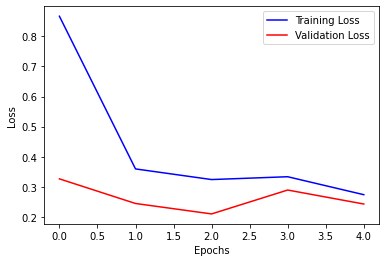

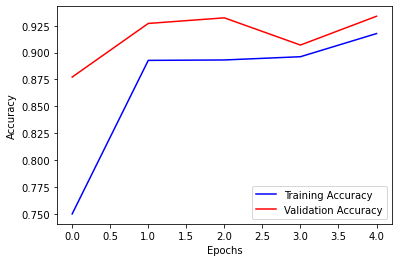

In [9]:
plt.figure()
plt.plot(train.history['loss'], 'blue')
plt.plot(train.history['val_loss'], 'red')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(train.history['accuracy'], 'blue')
plt.plot(train.history['val_accuracy'], 'red')
plt.legend(['Training Accuracy', 'Validation Accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')